# **Library AND Load data**

In [ ]:
from google.colab import drive
drive.mount('/content/Drive/')

Mounted at /content/Drive/


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [ ]:
# Chọn tệp JSON API Token từ máy tính của bạn
uploaded = files.upload()

# Di chuyển tệp JSON vào thư mục ~/.kaggle/
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Tải xuống bộ dữ liệu từ Kaggle
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Giải nén bộ dữ liệu
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# **Processing data**

In [ ]:
# Danh sách các labels
labels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']

# Đường dẫn đến thư mục chứa dữ liệu
path = "/content/COVID-19_Radiography_Dataset"

# Kết hợp đường dẫn
data_dir = os.path.join(path)

# Khởi tạo danh sách data
data = []

# Duyệt qua từng label
for id, label in enumerate(labels):
    # Duyệt qua từng tệp tin trong thư mục của label hiện tại
    for file in os.listdir(os.path.join(data_dir, label + '/images')):
        # Thêm thông tin tệp tin và label vào danh sách data
        data.append(['{}/images/{}'.format(label, file), label])

# Giữ lại 2 cột: 'image_file' và 'result'
data = pd.DataFrame(data, columns=['image_file', 'result'])

# Tạo cột 'path' trong DataFrame data, kết hợp đường dẫn đầy đủ
data['path'] = path + '/' + data['image_file']

In [ ]:
# Khởi tạo danh sách pixel_img để lưu trữ các ảnh
pixel_img = []

# Duyệt qua từng đường dẫn ảnh trong data
for image in tqdm(data['path']):
    # Mở ảnh và chuyển đổi sang ảnh đen trắng (grayscale)
    img = Image.open(image)
    img = ImageOps.grayscale(img)

    # Thay đổi kích thước ảnh thành 64x64 pixel
    img = img.resize((64, 64))

    # Chuyển đổi ảnh thành mảng numpy
    img = np.asarray(img)

    # Thay đổi hình dạng của ảnh để có kích thước (64, 64, 1)
    img = img.reshape((64, 64, 1))

    # Thêm ảnh vào danh sách pixel_img
    pixel_img.append(img)

# Chuyển đổi danh sách pixel_img thành mảng numpy
pixel_img = np.array(pixel_img)

# Tạo nhãn cho ảnh dựa trên label từ data
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity': 2, 'Viral Pneumonia': 3})

100%|██████████| 21165/21165 [00:52<00:00, 403.98it/s]


In [ ]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train_all, X_test_all, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

# Số lượng lớp
num_classes = len(np.unique(y_train))

# Chuyển đổi nhãn thành one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Chuẩn hóa giá trị của dữ liệu hình ảnh về khoảng [0, 1]
X_train = X_train_all.astype('float32') / 255
X_test = X_test_all.astype('float32') / 255

# Kích thước đầu vào
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
def evaluate_model(model, X_test, y_test):
    # Dự đoán nhãn của tập kiểm tra
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Tính toán các thông số đánh giá
    accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
    report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

    # In ra các thông số đánh giá
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)
    print("\nPrecision, Recall, F1-score:\n")
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average=None)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average=None)
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average=None)
    for i in range(len(labels)):
        print(labels[i])
        print("Precision:", precision[i])
        print("Recall:", recall[i])
        print("F1-score:", f1[i])
        print()

    # Tạo ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# **3.5. ConvNet (CNN1)**

## ConvNet (CNN1)

In [ ]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [ ]:
# Khởi tạo mô hình CNN
cnn1_model = keras.Sequential(
    [
        # Input layer
        keras.Input(shape=input_shape),

        # Convolutional layers
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),  # 32 filters, 3x3 kernel, "same" padding
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),  # 32 filters, 3x3 kernel, "valid" padding

        # Max pooling layer
        layers.MaxPooling2D(pool_size=(2,2)),  # 2x2 pool size

        # Dropout layer
        layers.Dropout(0.2, seed=235),  # Dropout rate of 0.2 (20%)

        # Convolutional layers
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),  # 32 filters, 3x3 kernel, "same" padding
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),  # 32 filters, 3x3 kernel, "valid" padding

        # Max pooling layer
        layers.MaxPooling2D(pool_size=(2,2)),  # 2x2 pool size

        # Dropout layer
        layers.Dropout(0.2, seed=235),  # Dropout rate of 0.2 (20%)

        # Convolutional layers
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),  # 32 filters, 3x3 kernel, "same" padding
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),  # 32 filters, 3x3 kernel, "valid" padding

        # Max pooling layer
        layers.MaxPooling2D(pool_size=(2,2)),  # 2x2 pool size

        # Dropout layer
        layers.Dropout(0.2, seed=235),  # Dropout rate of 0.2 (20%)

        # Flatten layer
        layers.Flatten(),

        # Dropout layer
        layers.Dropout(0.5, seed=235),  # Dropout rate of 0.5 (50%)

        # Dense layers
        layers.Dense(512, activation="relu"),  # 512 units with ReLU activation
        layers.Dense(num_classes, activation="softmax"),  # Output layer with softmax activation
    ]
)

# Hiển thị thông tin của mô hình
cnn1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        9248      
                                                        

In [ ]:
cnn1_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn1_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
133/133 [==============================] - 19s 43ms/step - loss: 1.1004 - accuracy: 0.5232 - val_loss: 0.9127 - val_accuracy: 0.6369
Epoch 2/50
133/133 [==============================] - 5s 35ms/step - loss: 0.8003 - accuracy: 0.6707 - val_loss: 0.6929 - val_accuracy: 0.7167
Epoch 3/50
133/133 [==============================] - 5s 34ms/step - loss: 0.7068 - accuracy: 0.7156 - val_loss: 0.6086 - val_accuracy: 0.7571
Epoch 4/50
133/133 [==============================] - 4s 34ms/step - loss: 0.6441 - accuracy: 0.7497 - val_loss: 0.7064 - val_accuracy: 0.7314
Epoch 5/50
133/133 [==============================] - 5s 35ms/step - loss: 0.5978 - accuracy: 0.7642 - val_loss: 0.7846 - val_accuracy: 0.6567
Epoch 6/50
133/133 [==============================] - 4s 34ms/step - loss: 0.5479 - accuracy: 0.7867 - val_loss: 0.5376 - val_accuracy: 0.8167
Epoch 7/50
133/133 [==============================] - 5s 35ms/step - loss: 0.5090 - accuracy: 0.8046 - val_loss: 0.6959 - val_accuracy: 0.692

133/133 [==============================] - 1s 2ms/step
Accuracy: 0.9019607843137255

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.92      0.89      0.91      2038
          COVID       0.96      0.92      0.94       723
   Lung_Opacity       0.83      0.89      0.86      1203
Viral Pneumonia       0.95      0.94      0.95       269

       accuracy                           0.90      4233
      macro avg       0.92      0.91      0.91      4233
   weighted avg       0.90      0.90      0.90      4233


Precision, Recall, F1-score:

Normal
Precision: 0.9220253164556962
Recall: 0.8935230618253189
F1-score: 0.9075504610017443

COVID
Precision: 0.9556509298998569
Recall: 0.9239280774550485
F1-score: 0.939521800281294

Lung_Opacity
Precision: 0.8315301391035549
Recall: 0.8944305901911886
F1-score: 0.8618342010412495

Viral Pneumonia
Precision: 0.9547169811320755
Recall: 0.9405204460966543
F1-score: 0.9475655430711611



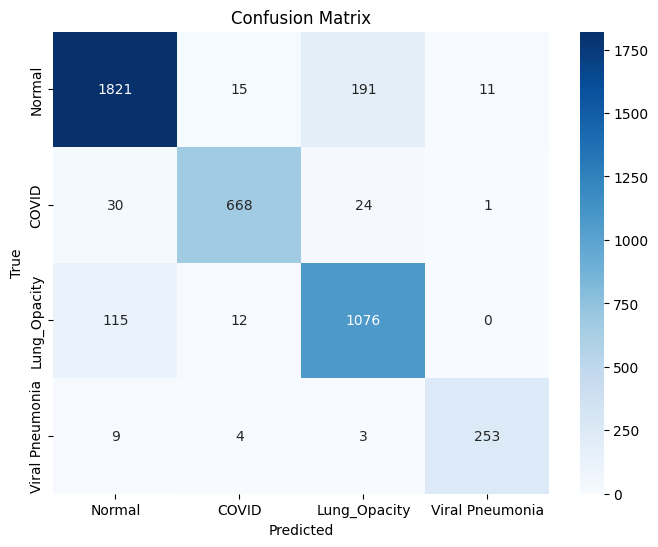

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn1_model, X_test, y_test)

In [ ]:
# save
cnn1_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn1_normal.h5")

## ConvNet (CNN1) - Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
cnn1_model_Oversampling = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn1_model_Oversampling.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 32)        9248      
                                                      

In [ ]:
num_samples = np.bincount(np.argmax(y_train, axis=1))

max_samples = max(num_samples)
oversampling_ratio = 2
sampling_strategy = {label: int(count * oversampling_ratio) for label, count in enumerate(num_samples)}
# Reshape dữ liệu hình ảnh thành ma trận 2 chiều
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Sử dụng RandomOverSampler với dữ liệu đã được làm phẳng
over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train_oversampled_flattened, y_train_oversampled = over_sampler.fit_resample(X_train_flattened, y_train)

# Đưa dữ liệu trở lại kích thước ban đầu
X_train_oversampled = X_train_oversampled_flattened.reshape(X_train_oversampled_flattened.shape[0], input_shape[0], input_shape[1], input_shape[2])

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (16308) in class 0 will be larger than the number of samples in the majority class (class #0 -> 8154)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (9618) in class 2 will be larger than the number of samples in the majority class (class #0 -> 8154)
  warnings.warn(


In [ ]:
cnn1_model_Oversampling.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn1_model_Oversampling.fit(X_train_oversampled, y_train_oversampled, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
265/265 [==============================] - 17s 41ms/step - loss: 0.9187 - accuracy: 0.6174 - val_loss: 0.6780 - val_accuracy: 0.7387
Epoch 2/50
265/265 [==============================] - 10s 37ms/step - loss: 0.6530 - accuracy: 0.7420 - val_loss: 0.5920 - val_accuracy: 0.7770
Epoch 3/50
265/265 [==============================] - 9s 35ms/step - loss: 0.5604 - accuracy: 0.7822 - val_loss: 0.6157 - val_accuracy: 0.7614
Epoch 4/50
265/265 [==============================] - 9s 35ms/step - loss: 0.4974 - accuracy: 0.8096 - val_loss: 0.5653 - val_accuracy: 0.7779
Epoch 5/50
265/265 [==============================] - 9s 35ms/step - loss: 0.4425 - accuracy: 0.8294 - val_loss: 0.4107 - val_accuracy: 0.8455
Epoch 6/50
265/265 [==============================] - 9s 34ms/step - loss: 0.4021 - accuracy: 0.8475 - val_loss: 0.4204 - val_accuracy: 0.8528
Epoch 7/50
265/265 [==============================] - 9s 33ms/step - loss: 0.3666 - accuracy: 0.8625 - val_loss: 0.4130 - val_accuracy: 0.84

133/133 [==============================] - 1s 4ms/step
Accuracy: 0.904086935979211

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.90      0.94      0.92      2038
          COVID       0.97      0.85      0.91       723
   Lung_Opacity       0.86      0.87      0.86      1203
Viral Pneumonia       0.94      0.95      0.95       269

       accuracy                           0.90      4233
      macro avg       0.92      0.90      0.91      4233
   weighted avg       0.91      0.90      0.90      4233


Precision, Recall, F1-score:

Normal
Precision: 0.9047844623401232
Recall: 0.9371933267909716
F1-score: 0.920703784044348

COVID
Precision: 0.9685534591194969
Recall: 0.8520055325034578
F1-score: 0.9065489330389993

Lung_Opacity
Precision: 0.8601973684210527
Recall: 0.8694929343308395
F1-score: 0.8648201736254651

Viral Pneumonia
Precision: 0.9444444444444444
Recall: 0.9479553903345725
F1-score: 0.9461966604823747



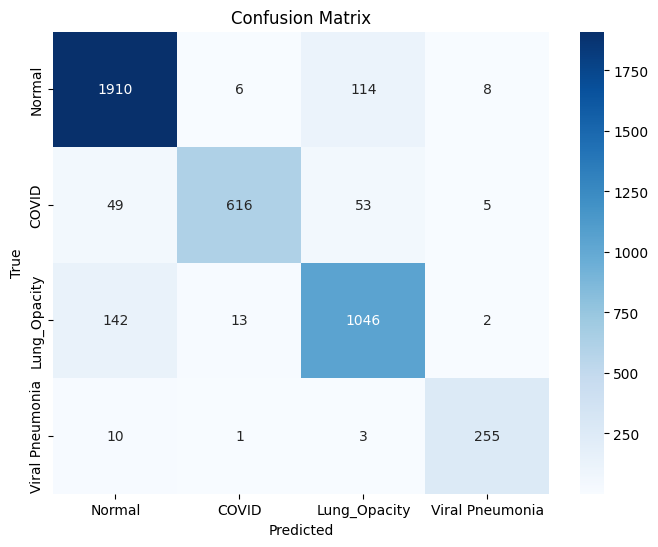

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn1_model_Oversampling, X_test, y_test)

In [ ]:
# save
cnn1_model_Oversampling.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn1_Oversampling.h5")

## ConvNet (CNN1) - Kết hợp Oversampling và Undersampling

In [ ]:
from imblearn.combine import SMOTEENN

In [ ]:
cnn1_over_under_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn1_over_under_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Kích thước đầu vào
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# Chuyển đổi X_train thành ma trận 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Áp dụng phương pháp Over-Under Sampling bằng SMOTEENN
sampler = SMOTEENN()
X_over_under_sampling, y_over_under_sampling = sampler.fit_resample(X_train_2d, y_train)
X_over_under_sampling = X_over_under_sampling.reshape(X_over_under_sampling.shape[0], 64, 64, 1)

In [ ]:
cnn1_over_under_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn1_over_under_model.fit(X_over_under_sampling, y_over_under_sampling, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
199/199 [==============================] - 10s 42ms/step - loss: 0.8039 - accuracy: 0.6605 - val_loss: 0.9892 - val_accuracy: 0.5563
Epoch 2/50
199/199 [==============================] - 7s 36ms/step - loss: 0.4679 - accuracy: 0.8141 - val_loss: 0.7738 - val_accuracy: 0.6938
Epoch 3/50
199/199 [==============================] - 7s 35ms/step - loss: 0.3728 - accuracy: 0.8544 - val_loss: 0.6708 - val_accuracy: 0.7486
Epoch 4/50
199/199 [==============================] - 7s 36ms/step - loss: 0.3152 - accuracy: 0.8787 - val_loss: 0.9793 - val_accuracy: 0.6534
Epoch 5/50
199/199 [==============================] - 7s 35ms/step - loss: 0.2660 - accuracy: 0.8999 - val_loss: 0.7036 - val_accuracy: 0.7623
Epoch 6/50
199/199 [==============================] - 7s 34ms/step - loss: 0.2319 - accuracy: 0.9135 - val_loss: 0.5287 - val_accuracy: 0.8082
Epoch 7/50
199/199 [==============================] - 7s 35ms/step - loss: 0.2036 - accuracy: 0.9248 - val_loss: 0.6827 - val_accuracy: 0.772

133/133 [==============================] - 1s 3ms/step
Accuracy: 0.8516418615639026

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.92      0.81      0.86      2038
          COVID       0.86      0.91      0.89       723
   Lung_Opacity       0.77      0.86      0.81      1203
Viral Pneumonia       0.78      0.99      0.88       269

       accuracy                           0.85      4233
      macro avg       0.83      0.89      0.86      4233
   weighted avg       0.86      0.85      0.85      4233


Precision, Recall, F1-score:

Normal
Precision: 0.9190396426577331
Recall: 0.8076545632973503
F1-score: 0.8597545050927135

COVID
Precision: 0.8617992177314211
Recall: 0.9142461964038727
F1-score: 0.8872483221476509

Lung_Opacity
Precision: 0.7728635682158921
Recall: 0.857024106400665
F1-score: 0.8127709893575089

Viral Pneumonia
Precision: 0.782991202346041
Recall: 0.9925650557620818
F1-score: 0.8754098360655738



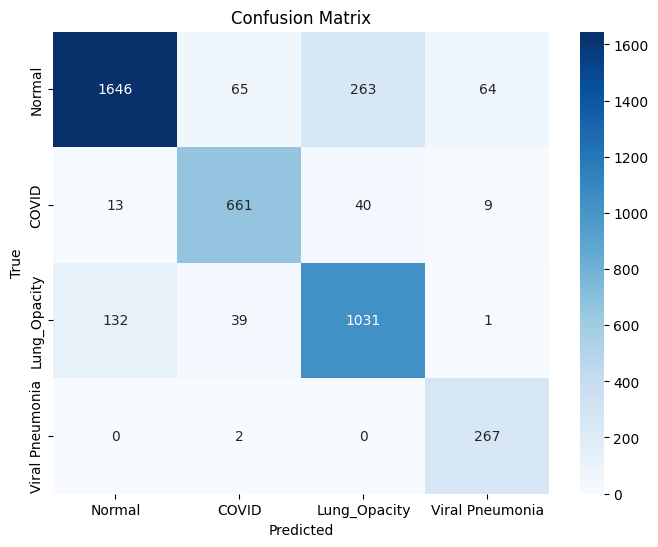

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn1_over_under_model, X_test, y_test)

In [ ]:
# save
cnn1_over_under_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn1_Over_Under.h5")

## ConvNet (CNN1) - Weighted Loss Function (sample weights)

In [ ]:
from sklearn.utils import compute_sample_weight

In [ ]:
cnn1_sample_weight_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn1_sample_weight_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_27 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Tính toán trọng số mẫu
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
cnn1_sample_weight_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn1_sample_weight_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), sample_weight=sample_weights)

Epoch 1/50
133/133 [==============================] - 35s 38ms/step - loss: 0.6652 - accuracy: 0.4261 - val_loss: 1.2169 - val_accuracy: 0.3156
Epoch 2/50
133/133 [==============================] - 5s 35ms/step - loss: 0.4815 - accuracy: 0.5732 - val_loss: 0.7813 - val_accuracy: 0.7123
Epoch 3/50
133/133 [==============================] - 5s 35ms/step - loss: 0.4194 - accuracy: 0.6270 - val_loss: 0.7204 - val_accuracy: 0.7038
Epoch 4/50
133/133 [==============================] - 5s 36ms/step - loss: 0.3800 - accuracy: 0.6619 - val_loss: 0.6404 - val_accuracy: 0.7456
Epoch 5/50
133/133 [==============================] - 5s 37ms/step - loss: 0.3493 - accuracy: 0.6952 - val_loss: 0.6221 - val_accuracy: 0.7434
Epoch 6/50
133/133 [==============================] - 5s 35ms/step - loss: 0.3254 - accuracy: 0.7120 - val_loss: 0.7990 - val_accuracy: 0.6589
Epoch 7/50
133/133 [==============================] - 5s 35ms/step - loss: 0.3090 - accuracy: 0.7314 - val_loss: 0.6231 - val_accuracy: 0.766

133/133 [==============================] - 0s 3ms/step
Accuracy: 0.8736120954405858

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.93      0.86      0.89      2038
          COVID       0.77      0.97      0.86       723
   Lung_Opacity       0.88      0.81      0.85      1203
Viral Pneumonia       0.82      0.98      0.89       269

       accuracy                           0.87      4233
      macro avg       0.85      0.91      0.87      4233
   weighted avg       0.88      0.87      0.87      4233


Precision, Recall, F1-score:

Normal
Precision: 0.9266877637130801
Recall: 0.8621197252208047
F1-score: 0.8932384341637011

COVID
Precision: 0.7740863787375415
Recall: 0.966804979253112
F1-score: 0.8597785977859779

Lung_Opacity
Precision: 0.8803956834532374
Recall: 0.8137988362427265
F1-score: 0.8457883369330453

Viral Pneumonia
Precision: 0.8167701863354038
Recall: 0.9776951672862454
F1-score: 0.8900169204737735



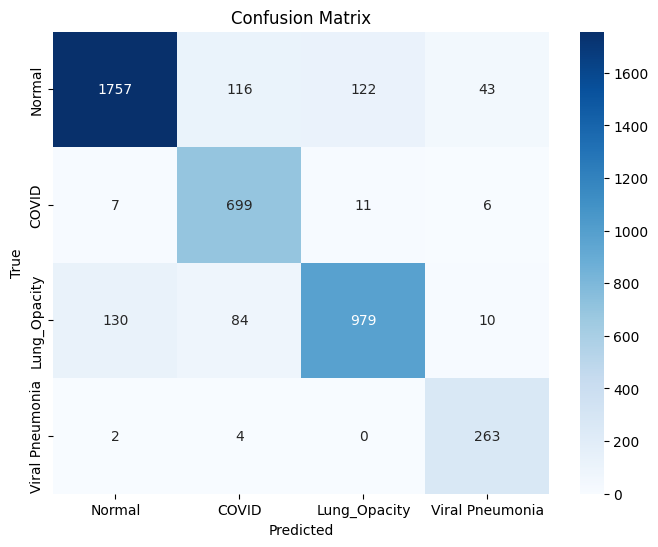

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn1_sample_weight_model, X_test, y_test)

In [ ]:
# save
cnn1_sample_weight_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn1_sample_weight.h5")

## ConvNet (CNN1) - Weighted Loss Function (class weights)

In [ ]:
from sklearn.utils import compute_class_weight

In [ ]:
cnn1_class_weight_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn1_class_weight_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_31 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Tính toán class weights dựa trên tần suất xuất hiện của từng lớp trong tập huấn luyện
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_img), y=label_img)
class_weights = dict(enumerate(class_weights))

In [ ]:
cnn1_class_weight_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn1_class_weight_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/50
133/133 [==============================] - 7s 40ms/step - loss: 1.0632 - accuracy: 0.4817 - val_loss: 0.9201 - val_accuracy: 0.6317
Epoch 2/50
133/133 [==============================] - 5s 35ms/step - loss: 0.7633 - accuracy: 0.6327 - val_loss: 0.7773 - val_accuracy: 0.6738
Epoch 3/50
133/133 [==============================] - 5s 36ms/step - loss: 0.6684 - accuracy: 0.6792 - val_loss: 0.6547 - val_accuracy: 0.7463
Epoch 4/50
133/133 [==============================] - 5s 36ms/step - loss: 0.6027 - accuracy: 0.7149 - val_loss: 0.5876 - val_accuracy: 0.7586
Epoch 5/50
133/133 [==============================] - 5s 36ms/step - loss: 0.5542 - accuracy: 0.7401 - val_loss: 0.5984 - val_accuracy: 0.7817
Epoch 6/50
133/133 [==============================] - 5s 36ms/step - loss: 0.5134 - accuracy: 0.7619 - val_loss: 0.5824 - val_accuracy: 0.7652
Epoch 7/50
133/133 [==============================] - 5s 37ms/step - loss: 0.4740 - accuracy: 0.7802 - val_loss: 0.4558 - val_accuracy: 0.8200

133/133 [==============================] - 0s 3ms/step
Accuracy: 0.8981809591306402

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.91      0.91      0.91      2038
          COVID       0.89      0.93      0.91       723
   Lung_Opacity       0.89      0.83      0.86      1203
Viral Pneumonia       0.85      0.98      0.91       269

       accuracy                           0.90      4233
      macro avg       0.89      0.91      0.90      4233
   weighted avg       0.90      0.90      0.90      4233


Precision, Recall, F1-score:

Normal
Precision: 0.9131927415399705
Recall: 0.9136408243375859
F1-score: 0.9134167279862644

COVID
Precision: 0.8853754940711462
Recall: 0.9294605809128631
F1-score: 0.9068825910931174

Lung_Opacity
Precision: 0.8924444444444445
Recall: 0.8345802161263508
F1-score: 0.8625429553264604

Viral Pneumonia
Precision: 0.8516129032258064
Recall: 0.9814126394052045
F1-score: 0.9119170984455959



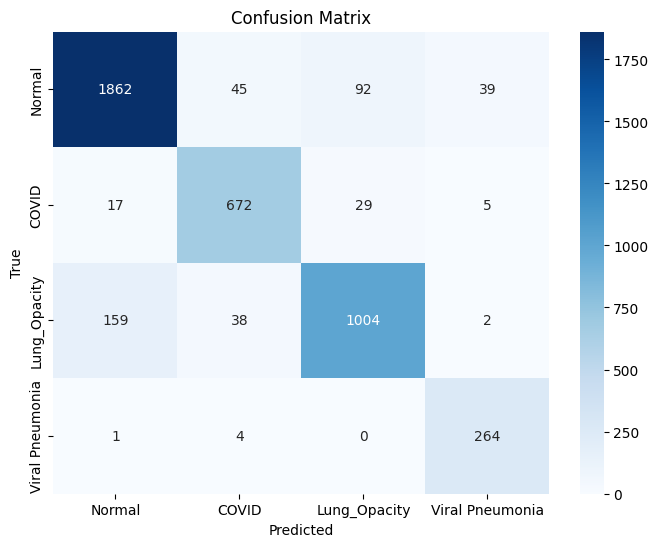

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn1_class_weight_model, X_test, y_test)

In [ ]:
# save
cnn1_class_weight_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn1_class_weight.h5")

## ConvNet (CNN1) - Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten

In [ ]:
# Tạo đối tượng ImageDataGenerator với các thuộc tính augmentation mong muốn
datagen = ImageDataGenerator(
    rotation_range=30,  # Góc xoay trong khoảng -30 đến 30 độ
    width_shift_range=0.1,  # Dịch chuyển theo chiều ngang trong khoảng -0.1 đến 0.1
    height_shift_range=0.1,  # Dịch chuyển theo chiều dọc trong khoảng -0.1 đến 0.1
    zoom_range=0.1,  # Tăng giảm tỷ lệ thu phóng trong khoảng 0.9 đến 1.1
    horizontal_flip=True,  # Lật ảnh theo chiều ngang (ngang dọc)
    vertical_flip=False,  # Không lật ảnh theo chiều dọc
    fill_mode='nearest'  # Sử dụng fill mode nearest
)

In [ ]:
cnn1_aug_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn1_aug_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_37 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_39 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Sao chép X_train và X_test để giữ nguyên dữ liệu gốc
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()

# Tiền xử lý cho X_train_aug
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_train_aug = X_train_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Tiền xử lý cho X_test_aug
X_test_aug = X_test_aug.reshape(X_test_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_test_aug = X_test_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Chuẩn bị dữ liệu augmentation
datagen.fit(X_train_aug)

# Áp dụng augmentation cho X_train_aug để tạo X_aug_train
augmented_X_train = datagen.flow(X_train_aug, y_train, batch_size=128)

In [ ]:
# Compile mô hình
cnn1_aug_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình với data augmentation
cnn1_aug_model.fit(augmented_X_train, epochs=50, validation_data=(X_test_aug, y_test))

Epoch 1/50
133/133 [==============================] - 27s 109ms/step - loss: 1.2020 - accuracy: 0.4774 - val_loss: 1.1997 - val_accuracy: 0.4815
Epoch 2/50
133/133 [==============================] - 16s 119ms/step - loss: 1.1902 - accuracy: 0.4816 - val_loss: 1.1889 - val_accuracy: 0.4815
Epoch 3/50
133/133 [==============================] - 13s 94ms/step - loss: 1.1894 - accuracy: 0.4816 - val_loss: 1.1872 - val_accuracy: 0.4815
Epoch 4/50
133/133 [==============================] - 17s 131ms/step - loss: 1.1884 - accuracy: 0.4816 - val_loss: 1.1874 - val_accuracy: 0.4815
Epoch 5/50
133/133 [==============================] - 13s 94ms/step - loss: 1.1885 - accuracy: 0.4816 - val_loss: 1.1874 - val_accuracy: 0.4815
Epoch 6/50
133/133 [==============================] - 12s 91ms/step - loss: 1.1883 - accuracy: 0.4816 - val_loss: 1.1875 - val_accuracy: 0.4815
Epoch 7/50
133/133 [==============================] - 13s 94ms/step - loss: 1.1882 - accuracy: 0.4816 - val_loss: 1.1879 - val_accura

133/133 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Accuracy: 0.48145523269548784

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.48      1.00      0.65      2038
          COVID       0.00      0.00      0.00       723
   Lung_Opacity       0.00      0.00      0.00      1203
Viral Pneumonia       0.00      0.00      0.00       269

       accuracy                           0.48      4233
      macro avg       0.12      0.25      0.16      4233
   weighted avg       0.23      0.48      0.31      4233


Precision, Recall, F1-score:

Normal
Precision: 0.48145523269548784
Recall: 1.0
F1-score: 0.649976080369957

COVID
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Lung_Opacity
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Viral Pneumonia
Precision: 0.0
Recall: 0.0
F1-score: 0.0



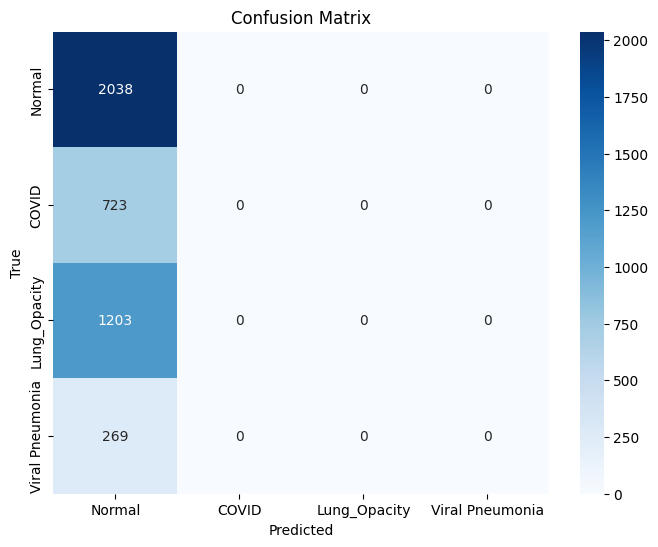

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn1_aug_model, X_test, y_test)

In [ ]:
# save
cnn1_aug_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn1_augmentation.h5")

## ConvNet (CNN1) - Kết hợp Data Augmentation và Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Tạo đối tượng ImageDataGenerator với các thuộc tính augmentation mong muốn
datagen = ImageDataGenerator(
    rotation_range=30,  # Góc xoay trong khoảng -30 đến 30 độ
    width_shift_range=0.1,  # Dịch chuyển theo chiều ngang trong khoảng -0.1 đến 0.1
    height_shift_range=0.1,  # Dịch chuyển theo chiều dọc trong khoảng -0.1 đến 0.1
    zoom_range=0.1,  # Tăng giảm tỷ lệ thu phóng trong khoảng 0.9 đến 1.1
    horizontal_flip=True,  # Lật ảnh theo chiều ngang (ngang dọc)
    vertical_flip=False,  # Không lật ảnh theo chiều dọc
    fill_mode='nearest'  # Sử dụng fill mode nearest
)

In [ ]:
cnn1_aug_over_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn1_aug_over_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_43 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_45 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Sao chép X_train và X_test để giữ nguyên dữ liệu gốc
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()
# Chuẩn bị dữ liệu augmentation
datagen.fit(X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1))  # Thay đổi kích thước thành (samples, 64, 64, 1)

# Áp dụng augmentation cho X_train_aug để tạo X_aug_train
augmented_X_train = datagen.flow(X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1), y_train, batch_size=128)

# Chuyển đổi dữ liệu X_aug_train thành 2D
X_aug_train_2d = augmented_X_train[0][0].reshape(augmented_X_train[0][0].shape[0], -1)

# Áp dụng Oversampling trên dữ liệu tăng cường 2D
over_sampler = RandomOverSampler(sampling_strategy='auto')
X_aug_oversampling, y_aug_oversampling = over_sampler.fit_resample(X_aug_train_2d, augmented_X_train[0][1])

# Đưa dữ liệu X_aug_oversampling về 3D
X_aug_oversampling = X_aug_oversampling.reshape(X_aug_oversampling.shape[0], 64, 64, 1)

# Tiền xử lý cho X_train_aug
X_train_aug = X_aug_oversampling.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Tiền xử lý cho X_test_aug
X_test_aug = X_test_aug.reshape(X_test_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_test_aug = X_test_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Kết hợp dữ liệu tăng cường và dữ liệu oversampling
X_combined = np.concatenate((X_aug_oversampling, X_test_aug), axis=0)
y_combined = np.concatenate((y_aug_oversampling, y_test), axis=0)

In [ ]:
# Biên dịch mô hình
cnn1_aug_over_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã được tăng cường và oversampling
cnn1_aug_over_model.fit(X_combined, y_combined, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
141/141 [==============================] - 5s 20ms/step - loss: 1.2218 - accuracy: 0.4628 - val_loss: 1.3369 - val_accuracy: 0.4815
Epoch 2/50
141/141 [==============================] - 2s 16ms/step - loss: 1.2061 - accuracy: 0.4690 - val_loss: 1.3472 - val_accuracy: 0.1732
Epoch 3/50
141/141 [==============================] - 2s 16ms/step - loss: 1.2024 - accuracy: 0.4728 - val_loss: 1.2046 - val_accuracy: 0.3744
Epoch 4/50
141/141 [==============================] - 2s 16ms/step - loss: 1.1909 - accuracy: 0.4805 - val_loss: 1.6066 - val_accuracy: 0.3324
Epoch 5/50
141/141 [==============================] - 3s 18ms/step - loss: 1.1828 - accuracy: 0.4854 - val_loss: 2.2187 - val_accuracy: 0.2563
Epoch 6/50
141/141 [==============================] - 2s 15ms/step - loss: 1.1834 - accuracy: 0.4883 - val_loss: 1.0840 - val_accuracy: 0.5514
Epoch 7/50
141/141 [==============================] - 2s 14ms/step - loss: 1.1751 - accuracy: 0.4910 - val_loss: 1.3289 - val_accuracy: 0.3910

133/133 [==============================] - 0s 3ms/step
Accuracy: 0.5745334278289629

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.60      0.79      0.68      2038
          COVID       0.36      0.13      0.19       723
   Lung_Opacity       0.56      0.57      0.56      1203
Viral Pneumonia       0.65      0.19      0.29       269

       accuracy                           0.57      4233
      macro avg       0.54      0.42      0.43      4233
   weighted avg       0.55      0.57      0.54      4233


Precision, Recall, F1-score:

Normal
Precision: 0.601952684941795
Recall: 0.7865554465161924
F1-score: 0.6819825569027866

COVID
Precision: 0.35797665369649806
Recall: 0.1272475795297372
F1-score: 0.18775510204081633

Lung_Opacity
Precision: 0.5554655870445344
Recall: 0.5702410640066501
F1-score: 0.5627563576702215

Viral Pneumonia
Precision: 0.6538461538461539
Recall: 0.1895910780669145
F1-score: 0.29394812680115273



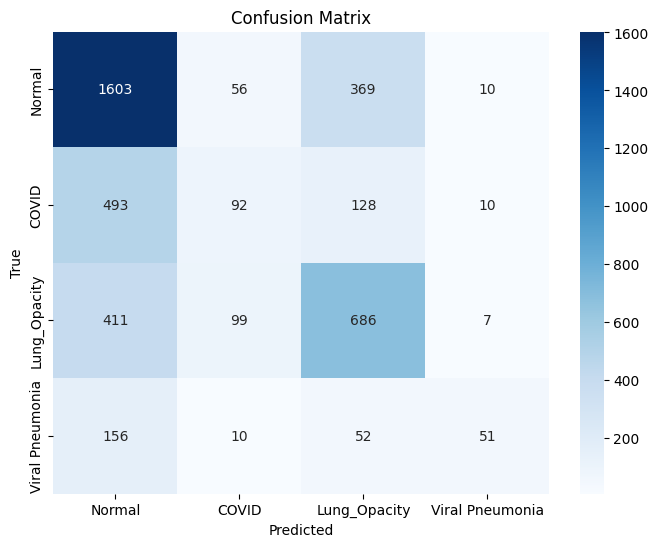

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn1_aug_over_model, X_test, y_test)

In [ ]:
# save
cnn1_aug_over_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn1_aug_over.h5")